In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
df['Age'] = imr.fit_transform(df[['Age']].values)

In [3]:
embarked_mapping = {'C':1,'Q':2,'S':3}
df['Embarked'] = df['Embarked'].map(embarked_mapping)

imr = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
df['Embarked'] = imr.fit_transform(df[['Embarked']].values)

inv_embarked_mapping = {v:k for k,v in embarked_mapping.items()}
df['Embarked'] = df['Embarked'].map(inv_embarked_mapping)

dummy_embarked = pd.get_dummies(df['Embarked'],prefix='Embarked')
df = pd.concat([df,dummy_embarked],axis=1)

In [4]:
sex_mapping = {'female':0,'male':1}
df['Sex'] = df['Sex'].map(sex_mapping)

In [35]:
df.to_csv('train_mod.csv',index=None)

In [6]:
from sklearn.cross_validation import train_test_split
train_columns = [u'Pclass',u'Sex', u'Age',u'SibSp', u'Parch',
                 u'Fare',u'Embarked_C',u'Embarked_Q', u'Embarked_S']
target_column = ['Survived']
X = df[train_columns].values
y = df[target_column].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [7]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [8]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    
    def __init__(self,estimator,k_features,scoring=accuracy_score,test_size=0.25,random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self,X,y):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            
            scores = []
            subsets = []
            
            for p in combinations(self.indices_,r=dim-1):
                score = self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            
            dim -= 1
            
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score

# KNeighbors

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
sbs = SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train[:,0])

<__main__.SBS instance at 0x7f2d0f239170>

(0.7, 1.1)

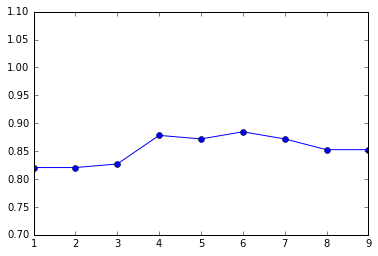

In [10]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.1])

In [11]:
sbs.subsets_[5]

(0, 1, 2, 5)

In [12]:
knn.fit(X_train_std[:,sbs.subsets_[5]],y_train[:,0])
y_train_predict = knn.predict(X_train_std[:,sbs.subsets_[5]])
y_test_predict = knn.predict(X_test_std[:,sbs.subsets_[5]])

In [13]:
print('train set accuracy: %.3f') % accuracy_score(y_train,y_train_predict)
print('\ntest set accuracy: %.3f') % accuracy_score(y_test,y_test_predict)

train set accuracy: 0.888

test set accuracy: 0.799


# Logistic Regression L1

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',C=10**(-1.5),random_state=1)
lr.fit(X_train_std,y_train[:,0])
y_train_predict = lr.predict(X_train_std)
y_test_predict = lr.predict(X_test_std)

In [32]:
print('train set accuracy: %.3f') % accuracy_score(y_train,y_train_predict)
print('\ntest set accuracy: %.3f') % accuracy_score(y_test,y_test_predict)

train set accuracy: 0.787

test set accuracy: 0.787


In [33]:
lr.coef_

array([[-0.40983242, -0.89800615,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

# Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',n_estimators=100,random_state=1,n_jobs=-1)
sbs = SBS(forest,k_features=1)
sbs.fit(X_train_std,y_train[:,0])

<__main__.SBS instance at 0x7f2d09a48128>

(0.7, 1.1)

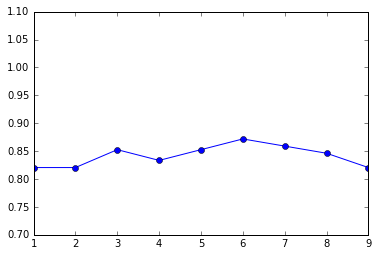

In [17]:
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.1])

In [18]:
forest.fit(X_train_std[:,sbs.subsets_[6]],y_train[:,0])
y_train_predict = forest.predict(X_train_std[:,sbs.subsets_[6]])
y_test_predict = forest.predict(X_test_std[:,sbs.subsets_[6]])

In [19]:
print('train set accuracy: %.3f') % accuracy_score(y_train,y_train_predict)
print('\ntest set accuracy: %.3f') % accuracy_score(y_test,y_test_predict)

train set accuracy: 0.812

test set accuracy: 0.791


In [27]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8),
 (0, 1, 2, 3, 4, 6, 7, 8),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 6),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 4),
 (0, 1, 4),
 (1, 4),
 (1,)]